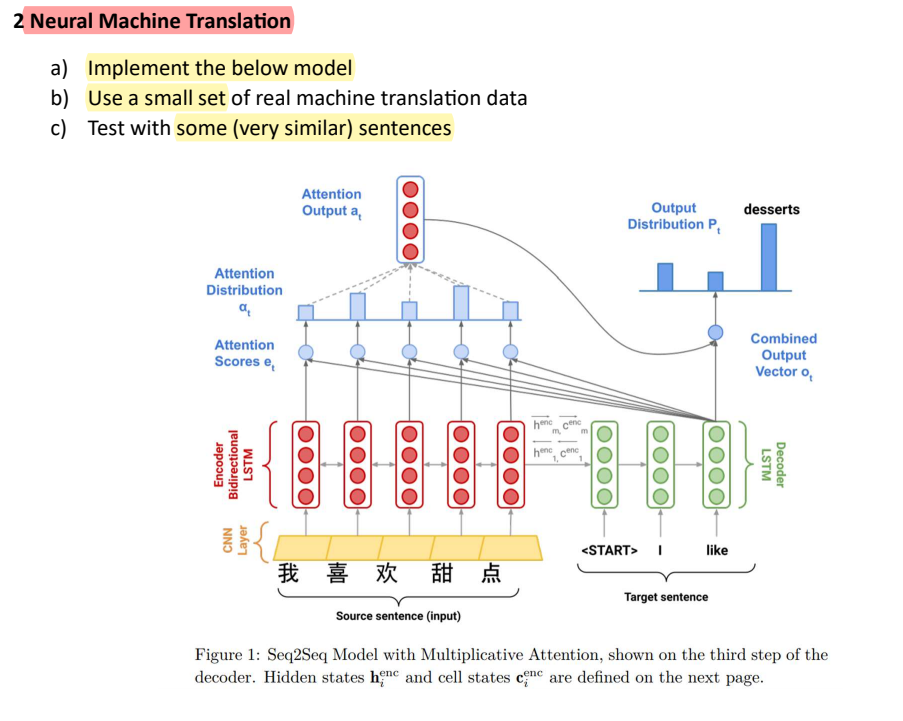


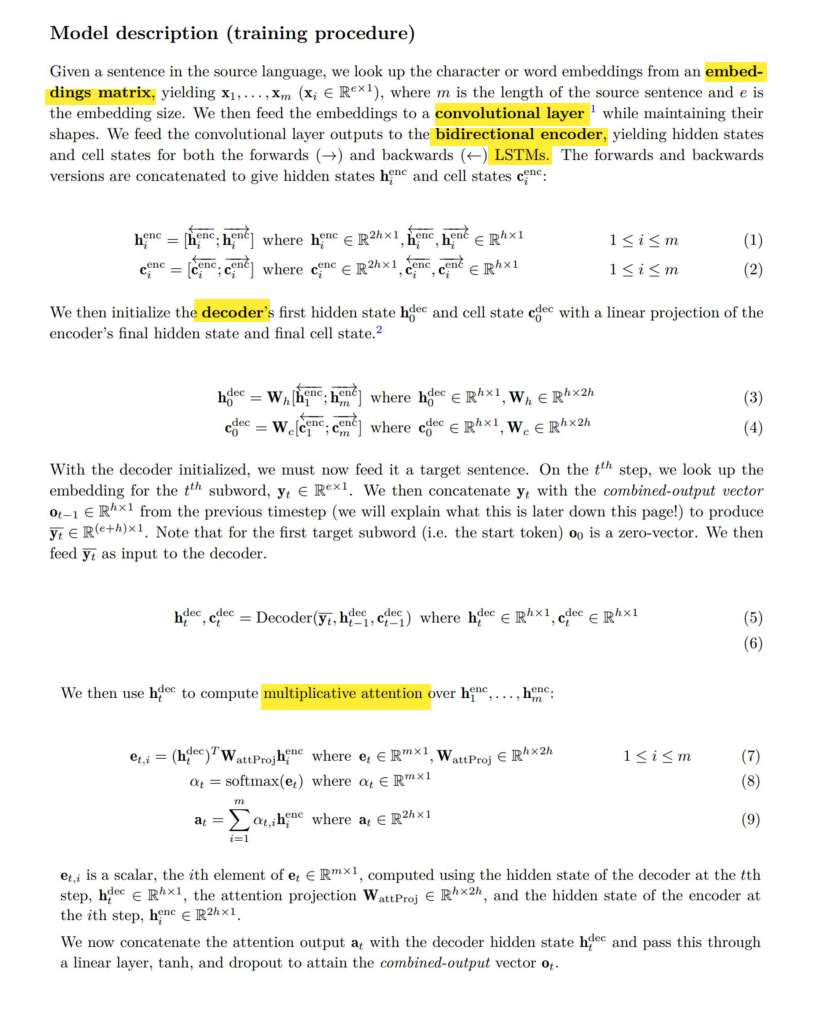
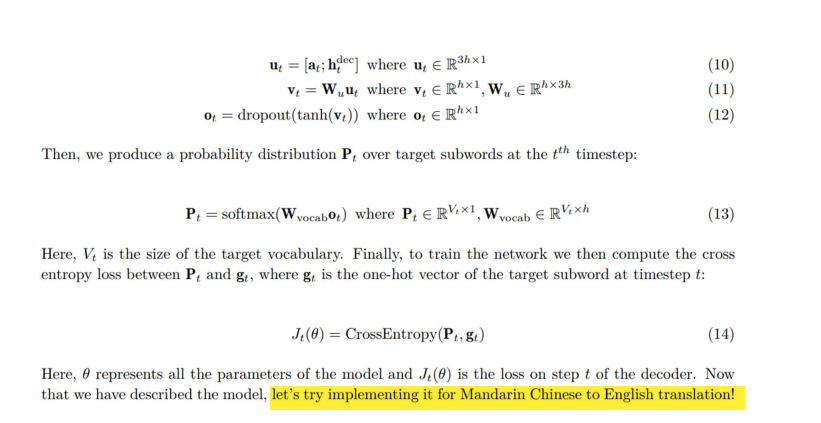

# Neural machine translation with attention

In [ ]:
import tensorflow as tf
print(tf.__version__)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

2.12.0


## Download and prepare the dataset

In [ ]:
# Download the file
path_to_file = tf.keras.utils.get_file(
    'cmn-eng.txt', origin='https://drive.google.com/u/0/uc?id=1_T-PDsl7Rd71B-DDJ1R1lDiwEk9ln0ML&export=download')


3365914/3365914 [==============================] - 0s 0us/step


In [ ]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  w = re.sub(r"([?.!,¿,，,。])", r" \1 ", w)
  # Pad each Chinese character with a space in front and a space after.
  w = re.sub(r'([\u4e00-\u9fff])', r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [ ]:
# Each element is treated as a separate word
preprocess_sentence(u'你好嗎').split(' ')

['<start>', '你', '好', '嗎', '<end>']

In [ ]:
# When I first started the project, the Cantonese language pair file was used.  However, there are simply not enough Cantonese sentence pair to generate good results for the translation.
# The preprocessing steps required for Chinese and Cantonese are the same though.
en_sentence = u"It'll soon go out of business if the food doesn't taste good."
yue_sentence = u"如果啲嘢食唔好食，都會好快執笠。"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(yue_sentence))

<start> it'll soon go out of business if the food doesn't taste good . <end>
<start> 如 果 啲 嘢 食 唔 好 食 ， 都 會 好 快 執 笠 。 <end>


In [ ]:
# 1. Clean the sentences
# 2. Return word pairs in the format: [ENGLISH, Chinese]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  samples = lines[:num_examples]
  
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')][:2]  for l in samples]
  return zip(*word_pairs)

In [ ]:
# Pick a random sample and make sure the files are preprocessed correctly
en, yu = create_dataset(path_to_file, None)
print(en[-1])
print(yu[-1])

<start> if a person has not had a chance to acquire his target language by the time he's an adult , he's unlikely to be able to reach native speaker level in that language . <end>
<start> 如 果 一 個 人 在 成 人 前 沒 有 機 會 習 得 目 標 語 言 ， 他 對 該 語 言 的 認 識 達 到 母 語 者 程 度 的 機 會 是 相 當 小 的 。 <end>


In [ ]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [ ]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### Limit the size of the dataset to experiment faster

To train faster, we limit the size of the dataset to 30,000 sentences (of course, translation quality degrades with less data):

In [ ]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [ ]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

18888 18888 4722 4722


In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [ ]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
4 ----> 我
24 ----> 們
5 ----> 的
177 ----> 友
236 ----> 情
50 ----> 會
274 ----> 長
316 ----> 久
331 ----> 留
722 ----> 存
3 ----> 。
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
123 ----> our
1720 ----> friendship
43 ----> will
97 ----> last
8 ----> a
133 ----> long
52 ----> time
3 ----> .
2 ----> <end>


### Create a tf.data dataset

In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 32
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 512
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([32, 46]), TensorShape([32, 36]))

In [ ]:
BUFFER_SIZE

18888

In [ ]:
steps_per_epoch

590

In [ ]:
vocab_inp_size

3613

In [ ]:
vocab_tar_size

6777

## Setup the encoder and decoder model

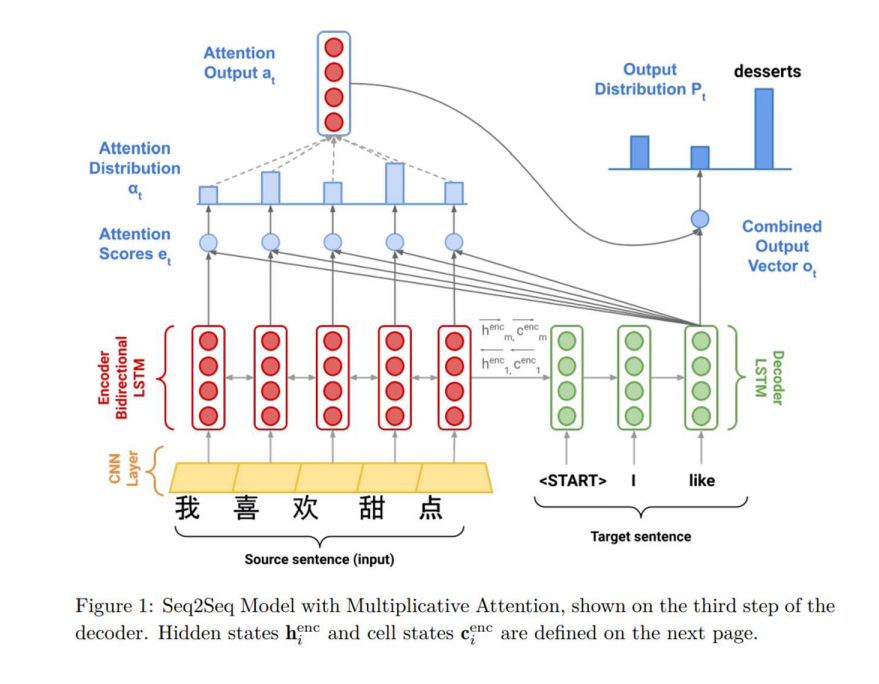

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.cnn = tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same')
        self.lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.enc_units,
                                                                        return_sequences=True,
                                                                        return_state=True,
                                                                        recurrent_initializer='glorot_uniform'))

    def call(self, x, hidden):
        x = self.embedding(x)
        x = self.cnn(x)
        output, forward_h, forward_c, backward_h, backward_c = self.lstm(x, initial_state = hidden)
        state_h = tf.concat([forward_h, backward_h], axis=-1)
        state_c = tf.concat([forward_c, backward_c], axis=-1)
        return output, [state_h, state_c]

    def initialize_hidden_state(self):
        return [tf.zeros((self.batch_sz, self.enc_units)) for _ in range(4)]


encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print('Encoder output shape: (batch size, sequence length, units)', sample_output.shape)
print('Encoder Hidden state shape: (batch size, units)', [hidden.shape for hidden in sample_hidden])


Encoder output shape: (batch size, sequence length, units) (32, 46, 1024)
Encoder Hidden state shape: (batch size, units) [TensorShape([32, 1024]), TensorShape([32, 1024])]


### Luong's multiplicative attention

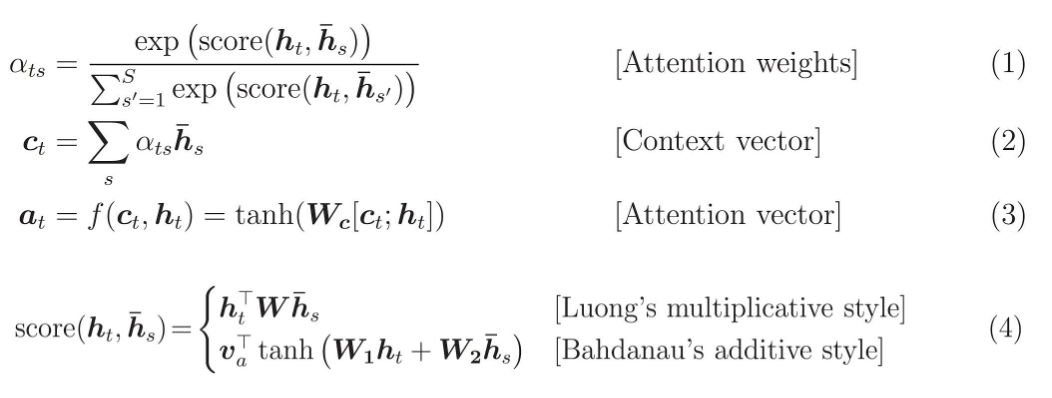

In [ ]:
class LuongAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LuongAttention, self).__init__()
        self.W = tf.keras.layers.Dense(units)

    def call(self, query, values):
        # Query shape: (batch_size, hidden size) 
        # Values shape: (batch_size, max_len, hidden size)
        
        # Apply the weight matrix W to the query
        query_transformed = tf.expand_dims(self.W(query), 1)  # shape: (batch_size, 1, units)
        
        # We transform the values to the same space as the query_transformed for dot product
        values_transformed = self.W(values)  # shape: (batch_size, max_len, units)

        # Calculate score as the dot product of the transformed query and values
        score = tf.linalg.matmul(query_transformed, values_transformed, transpose_b=True)  # shape: (batch_size, 1, max_len)
        score = tf.squeeze(score, [1])  # shape: (batch_size, max_len)

        # Apply softmax to calculate attention weights
        attention_weights = tf.nn.softmax(score, axis=-1)  # shape: (batch_size, max_len)
        attention_weights_expanded = tf.expand_dims(attention_weights, 1)  # shape: (batch_size, 1, max_len)

        # Use attention weights to calculate the context vector
        context_vector = attention_weights_expanded @ values  # shape: (batch_size, 1, hidden_units)
        context_vector = tf.squeeze(context_vector, 1)  # shape: (batch_size, hidden_units)

        return context_vector, attention_weights


In [ ]:
attention_layer = LuongAttention(units)
#attention_result, attention_weights = attention_layer(sample_hidden, sample_output)
attention_result, attention_weights = attention_layer(sample_hidden[0], sample_output)


print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (32, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (32, 46)


In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(2*self.dec_units,
                                         return_sequences=True,
                                         return_state=True,
                                         recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = LuongAttention(self.dec_units)


    def call(self, x, hidden, enc_output, training=False, mask=None):
        # hidden state is a list: [hidden_state, cell_state]
        hidden_state = hidden[0]
        cell_state = hidden[1]
        hidden = [hidden_state, cell_state]

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # passing the concatenated vector to the LSTM
        output, state_h, state_c = self.lstm(x, initial_state=hidden)  # LSTM returns output and two state tensors

        # Using Attention Layer
        attention_result, attention_weights = self.attention(state_h, enc_output)

        # Expand dimensions of attention_result
        attention_result = tf.expand_dims(attention_result, 1)

        # Concat attention output and decoder LSTM output 
        decoder_concat_input = tf.concat([output, attention_result], axis=-1)

        # output shape == (batch_size * 1, hidden_size)
        decoder_concat_input = tf.reshape(decoder_concat_input, (-1, decoder_concat_input.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(decoder_concat_input)

        return x, [state_h, state_c], attention_weights  # LSTM returns two states


decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)
print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (32, 6777)


## Define the optimizer and the loss function

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.0753
Epoch 1 Batch 100 Loss 1.1719
Epoch 1 Batch 200 Loss 1.1363
Epoch 1 Batch 300 Loss 0.8145
Epoch 1 Batch 400 Loss 0.8692
Epoch 1 Batch 500 Loss 0.9526
Epoch 1 Loss 1.0149
Time taken for 1 epoch 184.0225841999054 sec

Epoch 2 Batch 0 Loss 0.7146
Epoch 2 Batch 100 Loss 0.8710
Epoch 2 Batch 200 Loss 0.7210
Epoch 2 Batch 300 Loss 0.8233
Epoch 2 Batch 400 Loss 0.7285
Epoch 2 Batch 500 Loss 0.5929
Epoch 2 Loss 0.7590
Time taken for 1 epoch 113.78629541397095 sec

Epoch 3 Batch 0 Loss 0.7307
Epoch 3 Batch 100 Loss 0.6022
Epoch 3 Batch 200 Loss 0.6116
Epoch 3 Batch 300 Loss 0.5607
Epoch 3 Batch 400 Loss 0.6413
Epoch 3 Batch 500 Loss 0.5936
Epoch 3 Loss 0.6134
Time taken for 1 epoch 111.18216562271118 sec

Epoch 4 Batch 0 Loss 0.4942
Epoch 4 Batch 100 Loss 0.4051
Epoch 4 Batch 200 Loss 0.4771
Epoch 4 Batch 300 Loss 0.5115
Epoch 4 Batch 400 Loss 0.4672
Epoch 4 Batch 500 Loss 0.5360
Epoch 4 Loss 0.4795
Time taken for 1 epoch 112.74086284637451 sec

Epoch 5 Batch 0 Loss 

## Translate

Now that the model is trained, we can use it to do some translations.

In [ ]:
def evaluate(sentence):
    #attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)
    print(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    #hidden_state = [tf.zeros((1, units))]
    #cell_state = [tf.zeros((1, units))]
    #enc_out, enc_hidden = encoder(inputs, hidden_state, cell_state)

    hidden = [tf.zeros((1, units)) for _ in range(4)]
    enc_out, enc_hidden = encoder(inputs, hidden)
    

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        #attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, #attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, #attention_plot


In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence):
  #result, sentence, attention_plot = evaluate(sentence)
  result, sentence = evaluate(sentence)
  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  #attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]

## Restore the latest checkpoint and test

In [ ]:
translate(u'我同意。')

<start> 我 同 意 。 <end>
Input: <start> 我 同 意 。 <end>
Predicted translation: i agree . <end> 


In [ ]:
translate(u'他可能錯過了最後一班火車。')

<start> 他 可 能 錯 過 了 最 後 一 班 火 車 。 <end>
Input: <start> 他 可 能 錯 過 了 最 後 一 班 火 車 。 <end>
Predicted translation: he may have missed the next train . <end> 


In [ ]:
translate(u"我想睡覺")

<start> 我 想 睡 覺 <end>
Input: <start> 我 想 睡 覺 <end>
Predicted translation: i feel like going out . <end> 


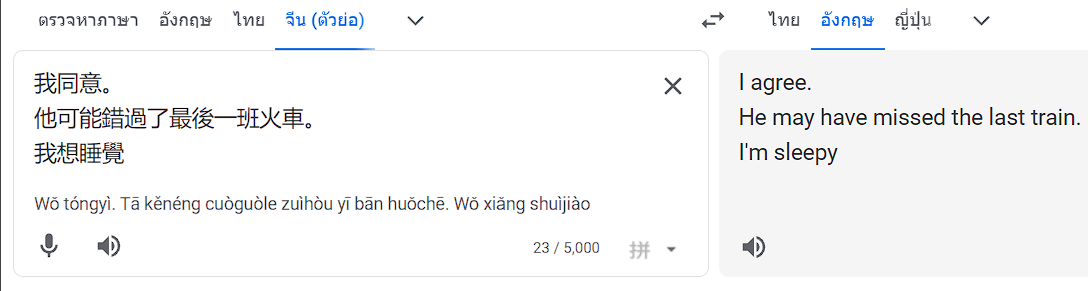